In [ ]:
!pip install torch torchvision opencv-python matplotlib numpy
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d michelheusser/handwritten-digits-and-operators
!unzip handwritten-digits-and-operators.zip -d /content/dataset

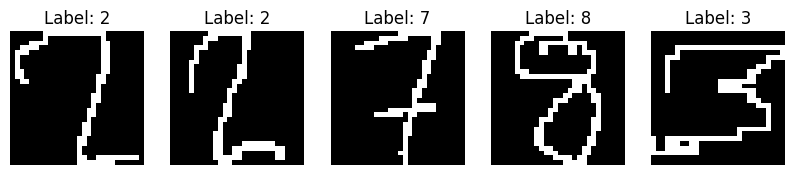

In [36]:

data = np.load('/content/dataset/CompleteDataSet_training_tuples.npy', allow_pickle=True)
images = [item[0] for item in data]
labels = [item[1] for item in data]

# Filter for digits (0-9) and operators (+, -)
label_map = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '+': 10, '-': 11}
filtered_data = [(img, label_map[label]) for img, label in zip(images, labels) if label in label_map]
images, labels = zip(*filtered_data)


resized_images = []
for img in images:
    if len(img.shape) == 3:
        img = img.squeeze()
    img_resized = cv2.resize(img, (28, 28), interpolation=cv2.INTER_AREA)
    img_normalized = img_resized / 255.0
    resized_images.append(img_normalized)

images = torch.tensor(np.array(resized_images), dtype=torch.float32).unsqueeze(1)  # Shape: (N, 1, 28, 28)
labels = torch.tensor(labels, dtype=torch.long)


plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(resized_images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

# Create dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

dataset = CustomDataset(images, labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [37]:

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 12)  # 12 classes
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.log_softmax(self.fc2(x))
        return x

model = CNNModel()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {e+1} - Loss: {running_loss/len(train_loader)}")

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total}%")

Epoch 1 - Loss: 1.7061130158368996
Epoch 2 - Loss: 0.5284091407809254
Epoch 3 - Loss: 0.37473832599155815
Epoch 4 - Loss: 0.30373238221993776
Epoch 5 - Loss: 0.2635539302807827
Epoch 6 - Loss: 0.23461459359559977
Epoch 7 - Loss: 0.21445843953287977
Epoch 8 - Loss: 0.19796072683740182
Epoch 9 - Loss: 0.18589334034687927
Epoch 10 - Loss: 0.17314343620339764
Accuracy: 94.50348112861855%


In [82]:
#uploaded = files.upload()
image_path = "/content/val.png"

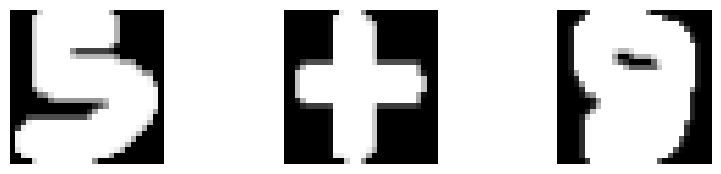

In [83]:
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((3,3), np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=1)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

characters = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 10 and h > 10:
        roi = thresh[y:y+h, x:x+w]
        size = max(w, h)
        pad_w = (size - w) // 2
        pad_h = (size - h) // 2
        roi_padded = cv2.copyMakeBorder(roi, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT, value=0)
        roi_resized = cv2.resize(roi_padded, (28, 28), interpolation=cv2.INTER_AREA)
        roi_resized = roi_resized / 255.0
        characters.append(roi_resized)

plt.figure(figsize=(10, 2))
for i, char in enumerate(characters):
    plt.subplot(1, len(characters), i+1)
    plt.imshow(char, cmap='gray')
    plt.axis('off')
plt.show()

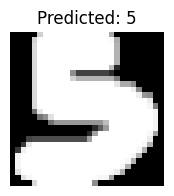

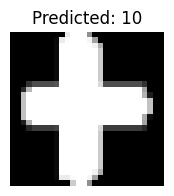

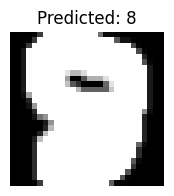

Predictions: [5, 10, 8]


In [84]:
predictions = []
model.eval()
with torch.no_grad():
    for i, char in enumerate(characters):
        char_tensor = torch.tensor(char, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        output = model(char_tensor)
        _, predicted = torch.max(output, 1)
        predictions.append(predicted.item())

        plt.figure(figsize=(2, 2))
        plt.imshow(char, cmap='gray')
        plt.title(f"Predicted: {predicted.item()}")
        plt.axis('off')
        plt.show()

# Ignore '='
if len(predictions) == 4:
    predictions = predictions[:-1]
print("Predictions:", predictions)

Result: 5+8 = 13


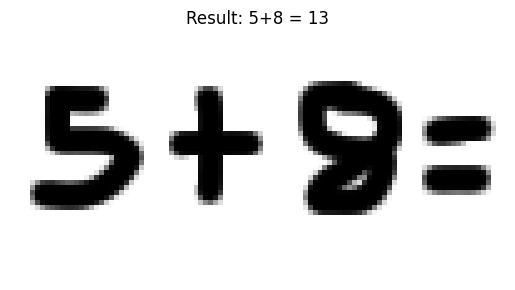

In [85]:
def solve_equation(predictions):
    equation = ''
    for pred in predictions:
        if pred < 10:
            equation += str(pred)
        elif pred == 10:
            equation += '+'
        elif pred == 11:
            equation += '-'
    try:
        left, op, right = equation.partition('+') if '+' in equation else equation.partition('-')
        left, right = int(left), int(right)
        result = left + right if op == '+' else left - right
        return f"{equation} = {result}"
    except:
        return "Invalid equation"

result = solve_equation(predictions)
print("Result:", result)

plt.imshow(cv2.imread(image_path))
plt.title(f"Result: {result}", fontsize=12)
plt.axis('off')
plt.show()